In [7]:
#!pip install geovoronoi
#!pip install descartes
#!pip install seaborn

In [1]:
import geopandas as gpd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import folium

from shapely.geometry import Point, LineString, Polygon
from geovoronoi import voronoi_regions_from_coords
from skmob.utils.plot import plot_gdf
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from scipy.spatial import Voronoi,voronoi_plot_2d

In [2]:
#Generate coordinates
def coord_lister(geom):
    coords = list(geom.exterior.coords)
    return (coords)


#Generating a list of index to drop from DF
def list_idx_to_drop(df,poly):
    to_drop = []
    for idx, el in enumerate(list(zip(df["lat"], df["lon"]))):
        point =Point(el[1],el[0])
        if not poly.contains(point):
            to_drop.append(idx)
    return to_drop  


def to_GeoDataFrame(region_polys):
    name=[]
    for i in range(1, len(region_polys) + 1):
        name.append('cell ' + str(i))
    gdf = gpd.GeoDataFrame(columns=['name','geometry'], crs={'init': 'epsg:4326'})
    gdf['name'] = name
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf


def get_voronoi_tessellation(poly_ch, points):
    vor = Voronoi(points, qhull_options='Qbb Qc Qx')
    #fig = voronoi_plot_2d(vor)
    #plt.show()
    region_polys, region_pts = voronoi_regions_from_coords(points, poly_ch)
    tess_voronoi = to_GeoDataFrame(region_polys)
    return tess_voronoi

## Cell Tower DataFrame

In [3]:
#Cell Tower DF taken from: https://opencellid.org/downloads.php

#Loading DataFrame
celle_francia = pd.read_csv("C:/Users/daddu/OneDrive/Desktop/MAGISTRALE/2° ANNO/GEOSPATIAL/HOMEWORKS/Files/208.csv", header=None)
#Restricting on GSM rows"
celle_francia = celle_francia[celle_francia[0] == "GSM"]
#Renaming columns of interest
celle_francia.rename(columns = {3:"LAC", 6:"lon", 7:"lat"}, inplace= True)

celle_francia.head()

,0,1,2,LAC,4,5,lon,lat,8,9,10,11,12,13
2,GSM,208,20,80,17939,0,-1.229193,49.292793,8732,63,1,1290277096,1290465250,0
3,GSM,208,20,80,18060,0,-1.214537,49.290525,10858,77,1,1290277096,1290464523,0
9,GSM,208,1,29188,3403,0,7.191202,43.709568,2297,200,1,1290426771,1662955409,0
13,GSM,208,1,29188,3516,0,7.186186,43.730398,706,102,1,1290426771,1662952231,0
14,GSM,208,1,29185,29308,0,7.204447,43.762039,9127,1998,1,1290426771,1519122677,0


# Lyon

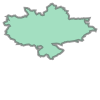

In [4]:
# France file taken from: https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_FRA_shp.zip

# Importing France GeoDataframe
francia = gpd.read_file("C:/Users/daddu/OneDrive/Desktop/MAGISTRALE/2° ANNO/GEOSPATIAL/HOMEWORKS/Files/gadm41_FRA_shp/gadm41_FRA_3.shp")

#Filtering for Lyon row
lione_df = francia[francia["NAME_3"] == "Lyon"]

#Extracting Lyon Polygon
lione_shape = list(lione_df.geometry.apply(coord_lister))
lione = Polygon(lione_shape[0])

lione

In [5]:
lista1 = list_idx_to_drop(celle_francia,lione)
celle_francia_lione = celle_francia.drop(celle_francia.index[lista1])

#200 rows of GSM cells in Lyone
celle_francia_lione[:200]

,0,1,2,LAC,4,5,lon,lat,8,9,10,11,12,13
1716,GSM,208,20,243,62600,0,4.816486,45.697391,11434,379,1,1310453371,1654411307,0
1717,GSM,208,20,243,36671,0,4.837901,45.700374,7769,84,1,1310453371,1504830946,0
1718,GSM,208,1,1795,18509,0,4.842093,45.696005,3560,193,1,1310453371,1510102302,0
1719,GSM,208,1,1795,18903,0,4.841046,45.701082,1885,179,1,1310453371,1504831865,0
1720,GSM,208,20,243,61112,0,4.840167,45.701903,6098,23,1,1310453371,1444107286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,GSM,208,10,601,32920,0,4.982227,45.749457,6166,38,1,1311237037,1347004821,0
3558,GSM,208,10,601,51985,0,4.991949,45.742815,12746,472,1,1311237037,1349397479,0
3559,GSM,208,10,601,51987,0,4.980322,45.751162,9715,138,1,1311237037,1349051615,0
3560,GSM,208,10,601,56995,0,4.969768,45.768455,18206,271,1,1311237037,1349173721,0


In [6]:
#Coordinates of those 200 cells as np.array
lista_coord_lione_np = np.array(list(zip(celle_francia_lione["lon"], celle_francia_lione["lat"])))

lista_coord_lione_np

array([[ 4.816486, 45.697391],
       [ 4.837901, 45.700374],
       [ 4.842093, 45.696005],
       ...,
       [ 4.877952, 45.719276],
       [ 4.877952, 45.719276],
       [ 4.839746, 45.874758]])

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


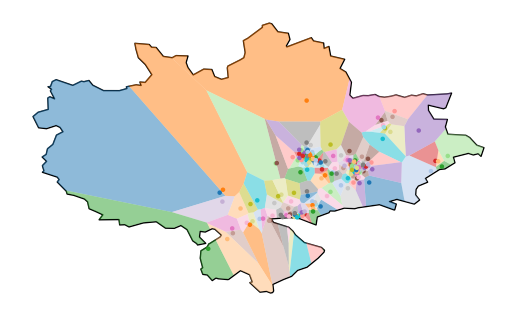

In [7]:
#Making Geovoronoi structure to plot
region_polys, region_pts = voronoi_regions_from_coords(lista_coord_lione_np[:200], lione)

#Plotting Lyone Geovoronoi
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, lione, region_polys, lista_coord_lione_np[:200], region_pts)
plt.show()

In [10]:
#Voronoi representation to plot on Folium
tess_voronoi_lione = get_voronoi_tessellation(lione, lista_coord_lione_np[:200])
tess_voronoi_lione.head()

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,geometry
0,cell 1,"POLYGON ((4.40830 45.63769, 4.39261 45.65361, ..."
1,cell 2,"POLYGON ((5.01147 45.65103, 5.01263 45.68788, ..."
2,cell 3,"POLYGON ((4.79134 45.76143, 4.76877 45.76483, ..."
3,cell 4,"POLYGON ((5.07388 45.68008, 5.08871 45.69069, ..."
4,cell 5,"POLYGON ((5.07341 45.67954, 5.07388 45.68008, ..."


In [11]:
plot_gdf(tess_voronoi_lione, zoom=9.5)

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\skmob\utils\plot.py:635: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  vertices = [list(zip(*p.exterior.xy)) for p in gway]


#  

# Lille

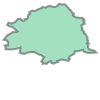

In [19]:
#Filtering for Lille row in France DF
lille_df = francia[francia["NAME_3"] == "Lille"]

#Extracting Lille Polygon
lille_shape = list(lille_df.geometry.apply(coord_lister))
lille = Polygon(lille_shape[0])

#Lille Polyogn
lille

In [20]:
lista2 = list_idx_to_drop(celle_francia, lille)
celle_francia_lille = celle_francia.drop(celle_francia.index[lista2])

#200 rows of GSM cells in Lille
celle_francia_lille[:200]

,0,1,2,LAC,4,5,lon,lat,8,9,10,11,12,13
923,GSM,208,20,475,46796,0,3.069377,50.772312,36584,582,1,1309958343,1642175165,0
924,GSM,208,1,512,44871,0,3.143136,50.748733,9622,310,1,1309958343,1531326013,0
1783,GSM,208,20,475,46572,0,2.834552,50.549973,25490,74,1,1310455132,1471255581,0
3531,GSM,208,1,512,50597,0,3.092644,50.756032,12198,59,1,1311156869,1505812332,0
4449,GSM,208,10,13401,25477,0,3.136320,50.595886,13442,263,1,1311347141,1420691361,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12446,GSM,208,10,65369,22002,0,3.076524,50.567406,6196,25,1,1312804162,1364203549,0
12447,GSM,208,10,13401,9833,0,3.068494,50.558765,29807,192,1,1312804162,1431950751,0
12455,GSM,208,10,1201,14436,0,3.037738,50.520608,6159,29,1,1312804412,1475862080,0
12546,GSM,208,10,13401,35899,0,3.081349,50.572192,4395,22,1,1312816335,1318927831,0


In [21]:
#Coordinates of those 200 cells as np.array
lista_coord_lille_np = np.array(list(zip(celle_francia_lille["lon"], celle_francia_lille["lat"])))

lista_coord_lille_np

array([[ 3.069377, 50.772312],
       [ 3.143136, 50.748733],
       [ 2.834552, 50.549973],
       ...,
       [ 2.825153, 50.548717],
       [ 3.037188, 50.4519  ],
       [ 3.16283 , 50.557995]])

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


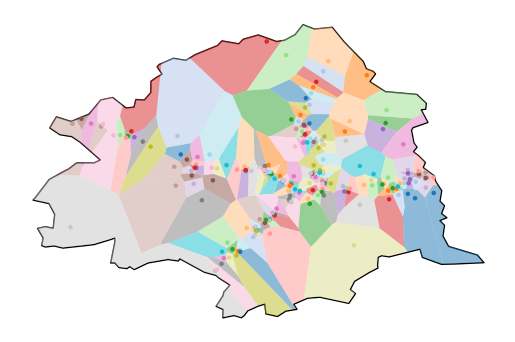

In [22]:
#Making Geovoronoi structure to plot
region_polys2, region_pts2 = voronoi_regions_from_coords(lista_coord_lille_np[:200], lille)

#Plotting Lyone Geovoronoi
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, lille, region_polys2, lista_coord_lille_np[:200], region_pts2)
plt.show()

In [23]:
#Voronoi representation to plot on Folium
tess_voronoi_lille = get_voronoi_tessellation(lille, lista_coord_lille_np[:200])
tess_voronoi_lille.head()

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,geometry
0,cell 1,"POLYGON ((3.25882 50.58553, 3.26850 50.60019, ..."
1,cell 2,"POLYGON ((3.11808 50.75369, 3.16288 50.73117, ..."
2,cell 3,"POLYGON ((3.16123 50.71112, 3.16117 50.71157, ..."
3,cell 4,"POLYGON ((3.11808 50.75369, 3.12315 50.78879, ..."
4,cell 5,"POLYGON ((3.22535 50.66447, 3.19047 50.67947, ..."


In [24]:
plot_gdf(tess_voronoi_lille, zoom=9.5)

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\skmob\utils\plot.py:635: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  vertices = [list(zip(*p.exterior.xy)) for p in gway]
